# Reading in intial dataset

In [86]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

train = pd.read_csv('titanic_train.csv')
final_test = pd.read_csv('titanic_test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [87]:
for col in train:
    print(f'{col} has {train[col].isna().sum()} na values')
    
train['Age'].mean()

PassengerId has 0 na values
Survived has 0 na values
Pclass has 0 na values
Name has 0 na values
Sex has 0 na values
Age has 177 na values
SibSp has 0 na values
Parch has 0 na values
Ticket has 0 na values
Fare has 0 na values
Cabin has 687 na values
Embarked has 2 na values


29.69911764705882

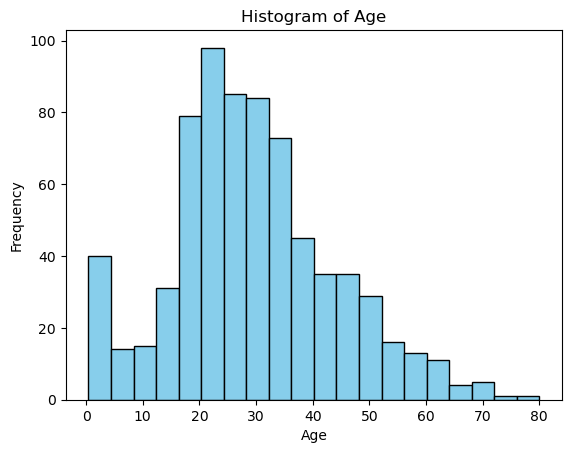

In [89]:
plt.hist(train['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

# Show plot
plt.show()

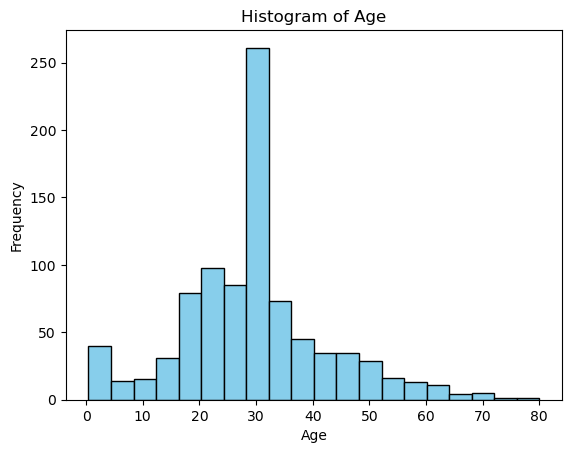

In [90]:
train["Age"] = train["Age"].fillna(round(train["Age"].mean()))

plt.hist(train['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

# Show plot
plt.show()

In [101]:
train["Sex"] = pd.get_dummies(train[["Sex"]], drop_first = True)

train["Embarked"].value_counts()

train["Embarked"] = train["Embarked"].fillna("S")
        

train["Embarked_C"] = pd.get_dummies(train[["Embarked"]])[["Embarked_C"]]
train["Embarked_S"] = pd.get_dummies(train[["Embarked"]])[["Embarked_S"]]
train["Embarked_Q"] = pd.get_dummies(train[["Embarked"]])[["Embarked_Q"]]

train = train.drop(["Name", "Ticket", "Embarked", "Cabin", "PassengerId"], axis = 1)

#Talk about dropping these columns; especially about PassengerId, because of how much worse the models got after dropping it.

train

KeyError: 'Embarked'

In [93]:
from sklearn.model_selection import train_test_split

x,y = train.iloc[:,np.r_[1:9]], train.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.3,
                                                    random_state = 0,
                                                    stratify=y)

print(len(x_train),len(y_train))

623 623


In [95]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_train_std = stdsc.fit_transform(x_train)
x_test_std = stdsc.transform(x_test)

## Sequential Backward selection (SBS) feature selection

### Code

In [96]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dim = x_train_std.shape[1]

for p in combinations(tuple(range(dim)), r=dim -1):
                      print(p)

(0, 1, 2, 3, 4, 5, 6)
(0, 1, 2, 3, 4, 5, 7)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 5, 6, 7)
(0, 1, 2, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
(0, 2, 3, 4, 5, 6, 7)
(1, 2, 3, 4, 5, 6, 7)


In [97]:
class SBS:
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, x,y):
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = self.test_size,
                                                        random_state = self.random_state)
        dim = x_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets = [self.indices_]
        score = self._calc_score(x_train,y_train,x_test,y_test,self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(x_train,y_train,x_test,y_test, p)
                scores.append(scores)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, x,y):
        return x[:,self.indices_]
    
    def _calc_score(self, x_train,y_train,x_test,y_test, indices):
        self.estimator.fit(x_train[:,indices],y_train)
        y_pred = self.estimator.predict(x_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score

## Use rf for feature selection

Import feature selection function and combine with an rf to find the 5 most important features, and then use those features with other models. Compare those models to general rf, as well as models that don't use different methods of feature selection (SBS, manual) or no feature selection at all.

In [98]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = x_train.columns
forest = RandomForestClassifier(n_estimators = 500,
                               random_state = 1,
                               n_jobs = 2)
forest.fit(x_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("2%d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

21) Fare                           0.279459
22) Sex                            0.251627
23) Age                            0.251433
24) Pclass                         0.087468
25) SibSp                          0.054057
26) Parch                          0.043381
27) Embarked_S                     0.016794
28) Embarked_C                     0.015780


It looks like Fare, Sex, and Age are the most important. I have a feeling that Fare and Pclass are highly correlated.

# Logistic Regression

In [102]:
highscore = 0
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100, solver = 'newton-cg', multi_class = 'multinomial')
lr.fit(x_train_std,y_train)

y_pred = lr.predict(x_test_std)

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore: {highscore.round(3)}")
else:
    print("Score = Highscore")

Accuracy: 0.806
New Highscore: 0.806


In [103]:
for i in range(1,100,5):
    lr_i = LogisticRegression(C = i, solver = 'newton-cg', multi_class = 'multinomial')
    print(f"C = {i}")
    lr_i.fit(x_train_std,y_train)

    y_pred = lr_i.predict(x_test_std)
    print(f'Accuracy for model {i}: {accuracy_score(y_test,y_pred)}')

C = 1
Accuracy for model 1: 0.8059701492537313
C = 6
Accuracy for model 6: 0.8059701492537313
C = 11
Accuracy for model 11: 0.8059701492537313
C = 16
Accuracy for model 16: 0.8059701492537313
C = 21
Accuracy for model 21: 0.8059701492537313
C = 26
Accuracy for model 26: 0.8059701492537313
C = 31
Accuracy for model 31: 0.8059701492537313
C = 36
Accuracy for model 36: 0.8059701492537313
C = 41
Accuracy for model 41: 0.8059701492537313
C = 46
Accuracy for model 46: 0.8059701492537313
C = 51
Accuracy for model 51: 0.8059701492537313
C = 56
Accuracy for model 56: 0.8059701492537313
C = 61
Accuracy for model 61: 0.8059701492537313
C = 66
Accuracy for model 66: 0.8059701492537313
C = 71
Accuracy for model 71: 0.8059701492537313
C = 76
Accuracy for model 76: 0.8059701492537313
C = 81
Accuracy for model 81: 0.8059701492537313
C = 86
Accuracy for model 86: 0.8059701492537313
C = 91
Accuracy for model 91: 0.8059701492537313
C = 96
Accuracy for model 96: 0.8059701492537313


## SBS + LR

In [104]:
from sklearn.feature_selection import SequentialFeatureSelector

sbs5 = SequentialFeatureSelector(lr, n_features_to_select = 5)
sbs.fit(x_train_std, y_train)

print(x_train.columns[list(np.where(sbs.get_support())[0])])

x_train_sbs = x_train_std[:,list(np.where(sbs.get_support())[0])]

lr_sbs = LogisticRegression(C = 100, solver = 'newton-cg', multi_class = 'multinomial')
lr_sbs.fit(x_train_sbs,y_train)

y_pred = lr_sbs.predict(x_test_std[:,list(np.where(sbs.get_support())[0])])

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore: {highscore.round(3)}")
else:
    print("Score = Highscore")

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'], dtype='object')
Accuracy: 0.795
Highscore: 0.806


Interesting that the accuracy went down a little bit after feature selection

In [105]:
sbs2 = SequentialFeatureSelector(lr, n_features_to_select = 2)
sbs2.fit(x_train_std, y_train)

print(x_train.columns[list(np.where(sbs2.get_support())[0])])

x_train_sbs2 = x_train_std[:,list(np.where(sbs2.get_support())[0])]

lr_sbs2 = LogisticRegression(C = 100, solver = 'newton-cg', multi_class = 'multinomial')
lr_sbs2.fit(x_train_sbs2,y_train)

y_pred = lr_sbs2.predict(x_test_std[:,list(np.where(sbs2.get_support())[0])])

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore: {highscore.round(3)}")
else:
    print("Score = Highscore")

Index(['Sex', 'SibSp'], dtype='object')
Accuracy: 0.799
Highscore: 0.806


Looks like you get a max of ~80% accuracy with the logistic regression models no matter how many variables you use, or what regularization coefficients you use.

# RF

In [106]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 25,
                               random_state=1,
                               n_jobs = 2)
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore!: {highscore.round(3)}")
else:
    print("Score = Highscore")

Accuracy: 0.784
Highscore: 0.806


In [107]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 50,
                               random_state=1,
                               n_jobs = 2)
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore!: {highscore.round(3)}")
else:
    print("Score = Highscore")

Accuracy: 0.806
Score = Highscore


In [ ]:
score_list = []
for i in list(range(1,500,5)):
    forest = RandomForestClassifier(n_estimators = i,
                               random_state=1,
                               n_jobs = 2)
    forest.fit(x_train,y_train)
    y_pred = forest.predict(x_test)
    score_list.append([accuracy_score(y_test,y_pred), f"n_estimators = {i}"])
    

max(score_list)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 31,
                               random_state=1,
                               n_jobs = 2)
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore!: {highscore.round(3)}")
else:
    print("Score = Highscore")

# Perceptron